### Driver-Specific Track Struggles:
Identify circuits where specific drivers consistently struggle or excel


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
data=pd.read_csv('../../data/processed/fully_integrated_data.csv')
data.columns

Index(['raceId', 'season', 'raceNumber', 'circuitId', 'prixName', 'raceDate',
       'driverId', 'constructorId', 'driverStartGridPos', 'driverFinalGridPos',
       'driverFinalRank', 'driverRacePoints', 'driverLapCount',
       'driverFatestLapNumber', 'driverFastestLapTime',
       'driverFastestLapSpeed', 'constructorName', 'constructorNationality',
       'constructorChampionshipStandingPoints',
       'constructorChampionshipStandingPosition',
       'constructorChampionshipStandingWins', 'constructorRacePoints',
       'driverDateOfBirth', 'driverNationality',
       'driverChampionshipStandingPoints',
       'driverChampionshipStandingPosition', 'driverChampionshipStandingWins',
       'circuitName', 'circuitLocation', 'circuitCountry', 'lat', 'lng', 'alt',
       'driverRaceResultStatus', 'driverName', 'driverAge', 'race_time'],
      dtype='object')

In [4]:
data.head()

,raceId,season,raceNumber,circuitId,prixName,raceDate,driverId,constructorId,driverStartGridPos,driverFinalGridPos,...,circuitName,circuitLocation,circuitCountry,lat,lng,alt,driverRaceResultStatus,driverName,driverAge,race_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,18,23,1,1.0,...,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,Finished,Jenson Button,45.0,01:34:15.784
1,1,2009,1,1,Australian Grand Prix,2009-03-29,22,23,2,2.0,...,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,Finished,Rubens Barrichello,53.0,01:34:16.591
2,1,2009,1,1,Australian Grand Prix,2009-03-29,15,7,20,3.0,...,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,Finished,Jarno Trulli,51.0,01:34:17.388
3,1,2009,1,1,Australian Grand Prix,2009-03-29,10,7,19,4.0,...,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,Finished,Timo Glock,43.0,01:34:20.219
4,1,2009,1,1,Australian Grand Prix,2009-03-29,4,4,10,5.0,...,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,Finished,Fernando Alonso,44.0,01:34:20.663


In [43]:
data['circuitName'].value_counts()

circuitName
Autodromo Nazionale di Monza     1836
Circuit de Monaco                1664
Silverstone Circuit              1436
Circuit de Spa-Francorchamps     1258
Circuit Gilles Villeneuve        1052
                                 ... 
Sebring International Raceway      19
Monsanto Park Circuit              16
Pescara Circuit                    16
AVUS                               15
Le Mans                            15
Name: count, Length: 77, dtype: int64

### We have  77 Circuits

In [ ]:
# Compute overall average finishing position (baseline) for each driver
driver_baseline = data.groupby('driverId')['driverFinalRank'].mean().reset_index()
driver_baseline.rename(columns={'driverFinalRank': 'overall_avg_finish'}, inplace=True)

# Merge baseline performance back into the main DataFrame
data = data.merge(driver_baseline, on='driverId', how='left')

# Compute average finishing position per driver per circuit
driver_circuit_perf = data.groupby(['driverId', 'circuitId', 'circuitName']).agg({
    'driverFinalRank': 'mean'
}).reset_index()
driver_circuit_perf.rename(columns={'driverFinalRank': 'circuit_avg_finish'}, inplace=True)

# Merge with overall baseline
driver_circuit_perf = driver_circuit_perf.merge(driver_baseline, on='driverId', how='left')

# Calculate deviation: 
# Positive deviation: driver finishes worse than overall average 
# Negative deviation: driver finishes better than overall average 
driver_circuit_perf['deviation'] = driver_circuit_perf['circuit_avg_finish'] - driver_circuit_perf['overall_avg_finish']

print("Driver-Specific Performance by Circuit:")
print(driver_circuit_perf.head())


Driver-Specific Performance by Circuit:
   driverId  circuitId                     circuitName  circuit_avg_finish  \
0         1          1  Albert Park Grand Prix Circuit            5.750000   
1         1          2    Sepang International Circuit            5.181818   
2         1          3   Bahrain International Circuit            3.705882   
3         1          4  Circuit de Barcelona-Catalunya            4.944444   
4         1          5                   Istanbul Park            4.428571   

   overall_avg_finish  deviation  
0            5.019663   0.730337  
1            5.019663   0.162155  
2            5.019663  -1.313781  
3            5.019663  -0.075218  
4            5.019663  -0.591091  


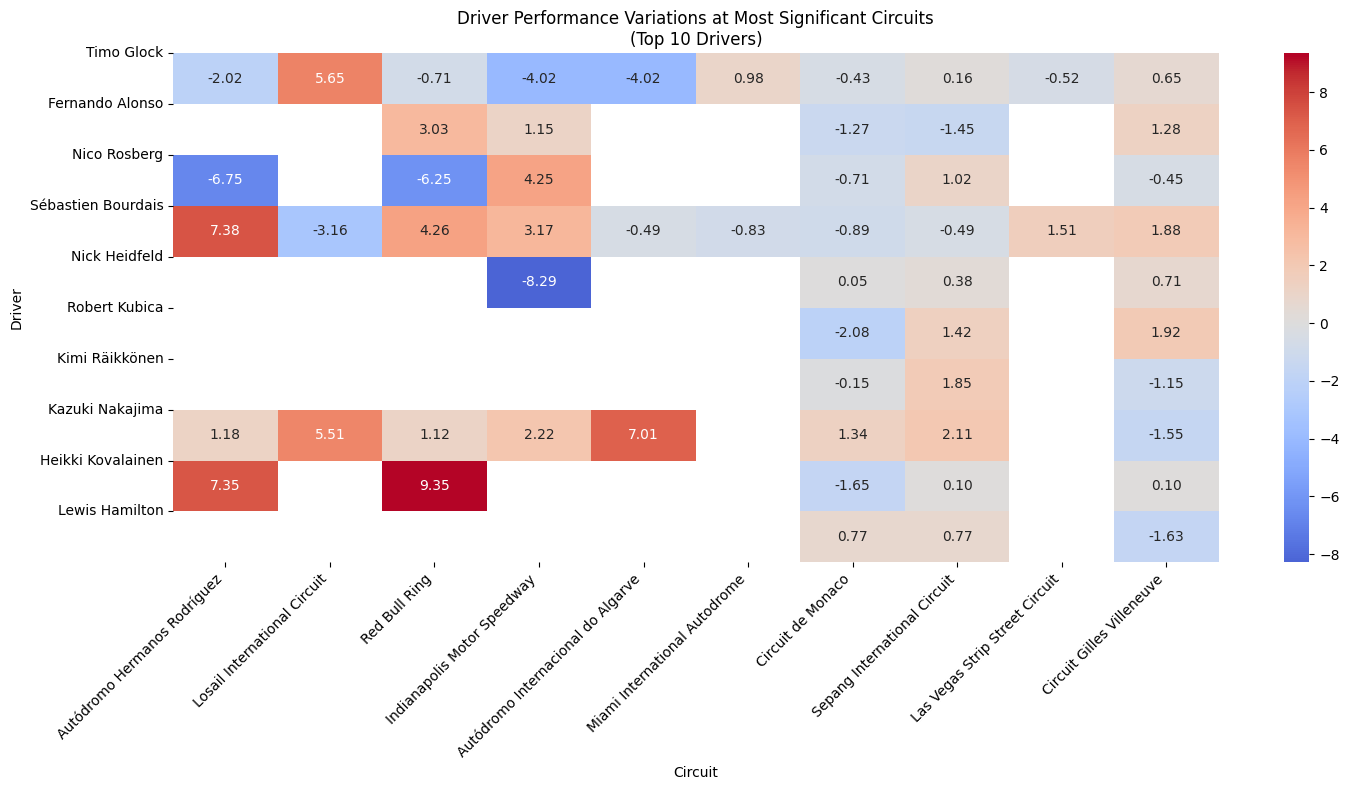

In [16]:
# Keep only top 10 drivers with enough races for meaningful analysis
min_races = 10
driver_race_counts = data.groupby('driverId').size()
qualified_drivers = driver_race_counts[driver_race_counts >= min_races].head(10).index

# Filter the pivot table for qualified drivers
pivot = driver_circuit_perf[driver_circuit_perf['driverId'].isin(qualified_drivers)].pivot(
    index='driverId', 
    columns='circuitName', 
    values='deviation'
)

# Get the mean absolute deviation for each circuit
circuit_mean_dev = pivot.abs().mean()

# Select top 5 and bottom 5 circuits by absolute mean deviation
significant_circuits = pd.concat([
    circuit_mean_dev.nlargest(5),
    circuit_mean_dev.nsmallest(5)
])

# Filter pivot table for only these circuits
pivot_filtered = pivot[significant_circuits.index]

# Create the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_filtered, 
            cmap='coolwarm', 
            center=0, 
            annot=True, 
            fmt='.2f',
            xticklabels=True)

# Add driver names to y-axis labels
driver_names = data[data['driverId'].isin(qualified_drivers)][['driverId', 'driverName']].drop_duplicates()
plt.yticks(range(len(driver_names)), driver_names['driverName'], rotation=0)

plt.title('Driver Performance Variations at Most Significant Circuits\n(Top 10 Drivers)')
plt.xlabel('Circuit')
plt.ylabel('Driver')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


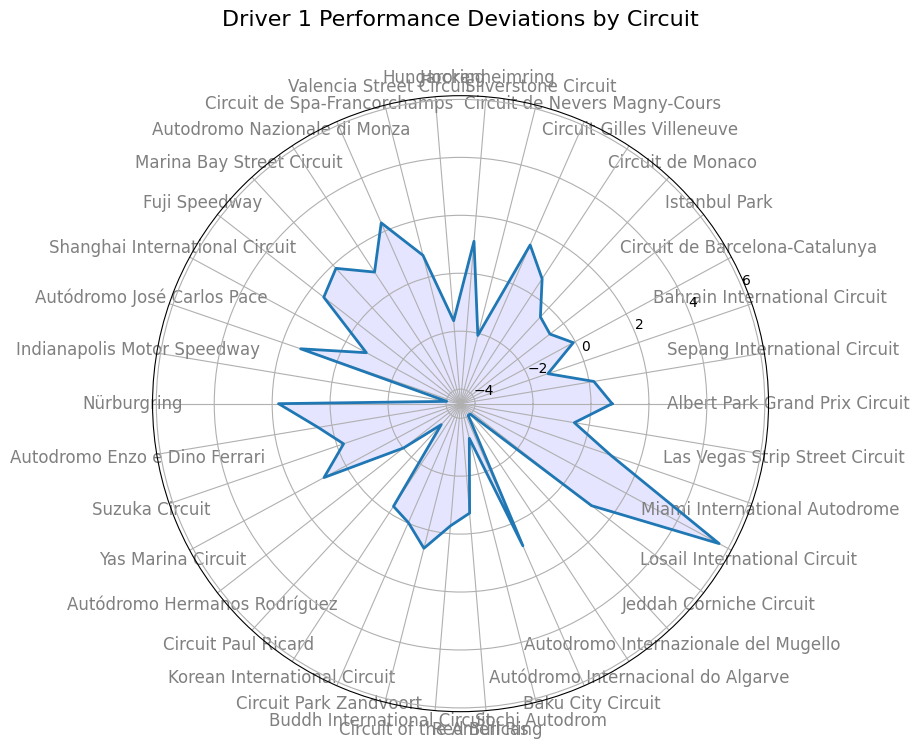

In [31]:


def plot_driver_radar_chart(driver_id, df_perf):
    driver_data = df_perf[df_perf['driverId'] == driver_id]
    if driver_data.empty:
        print(f"No data available for driver {driver_id}")
        return
    
    categories = list(driver_data['circuitName'])
    values = list(driver_data['deviation'])
    values += values[:1]
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    # Set up the radar chart
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=12)
    
    # Plot data
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Driver {driver_id}")
    ax.fill(angles, values, 'b', alpha=0.1)
    
    # Add title and legend
    plt.title(f"Driver {driver_id} Performance Deviations by Circuit", size=16, y=1.1)
    plt.show()

#radar chart for driver with ID 1
plot_driver_radar_chart(1, driver_circuit_perf)


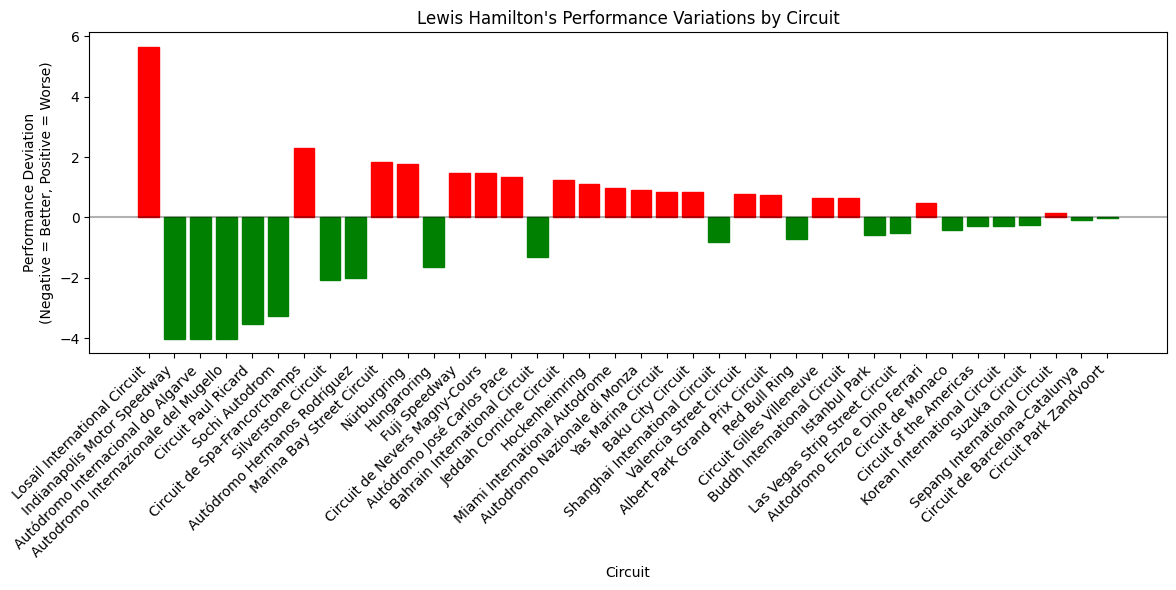

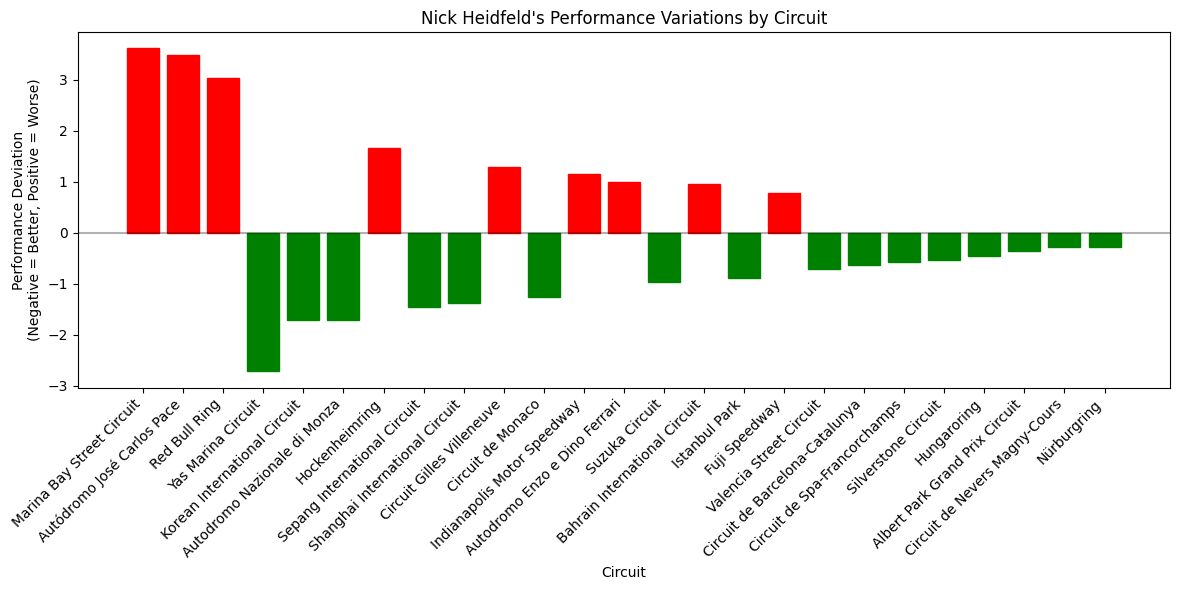

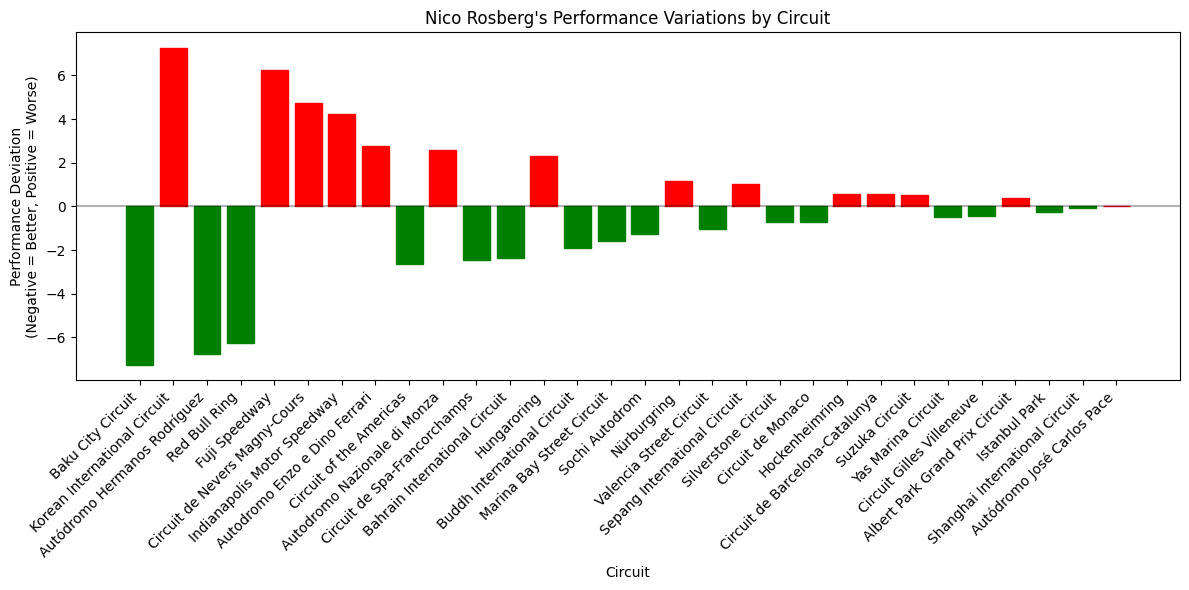

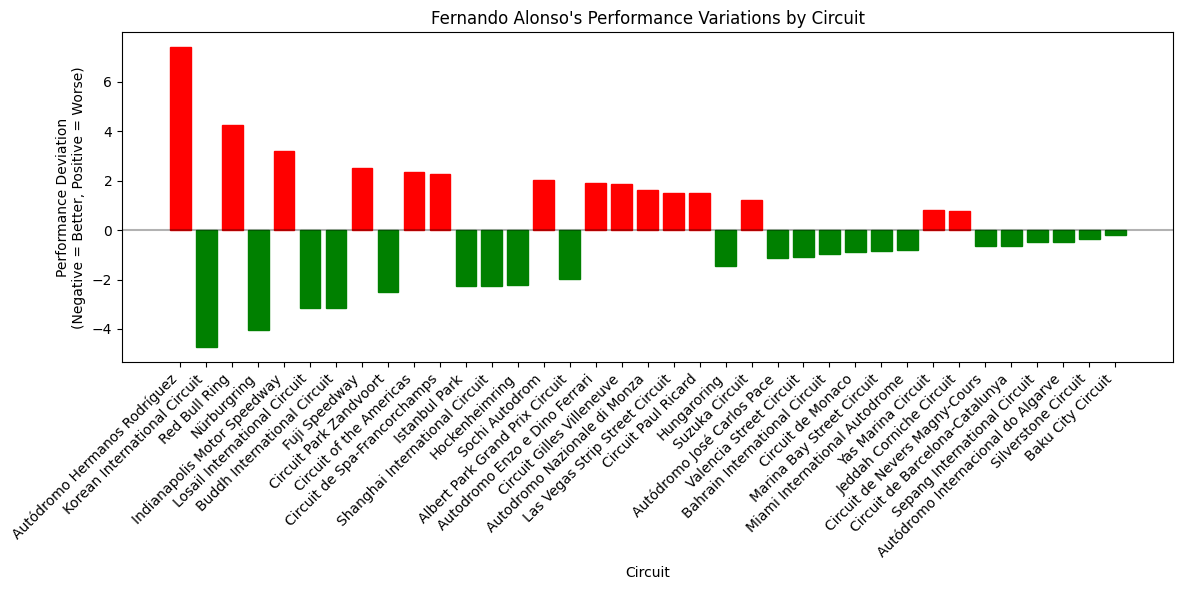

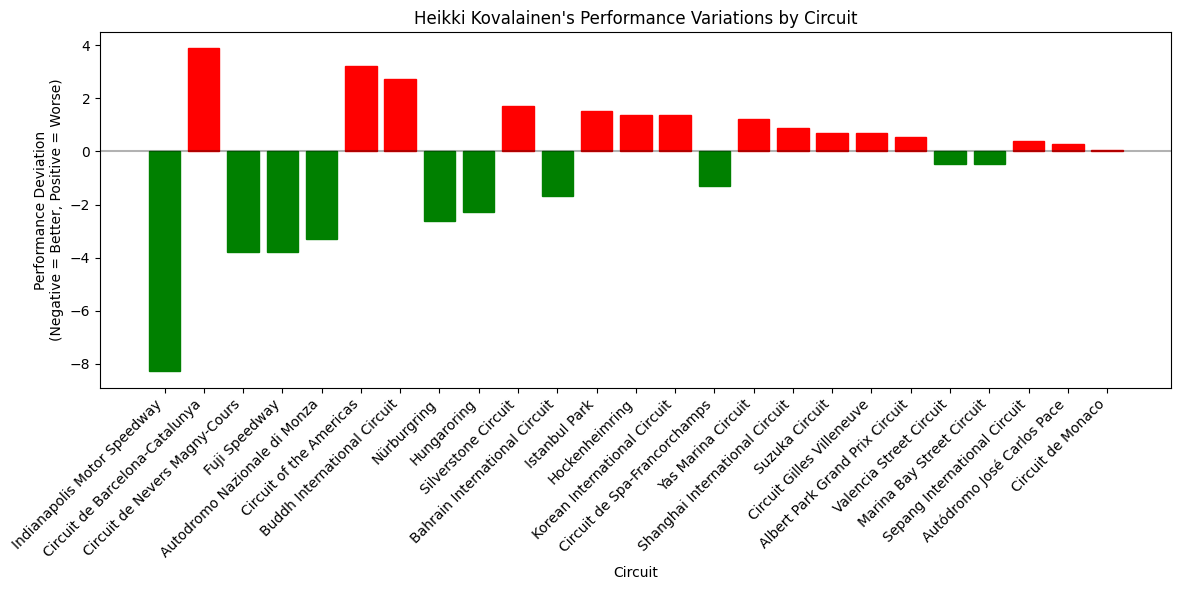

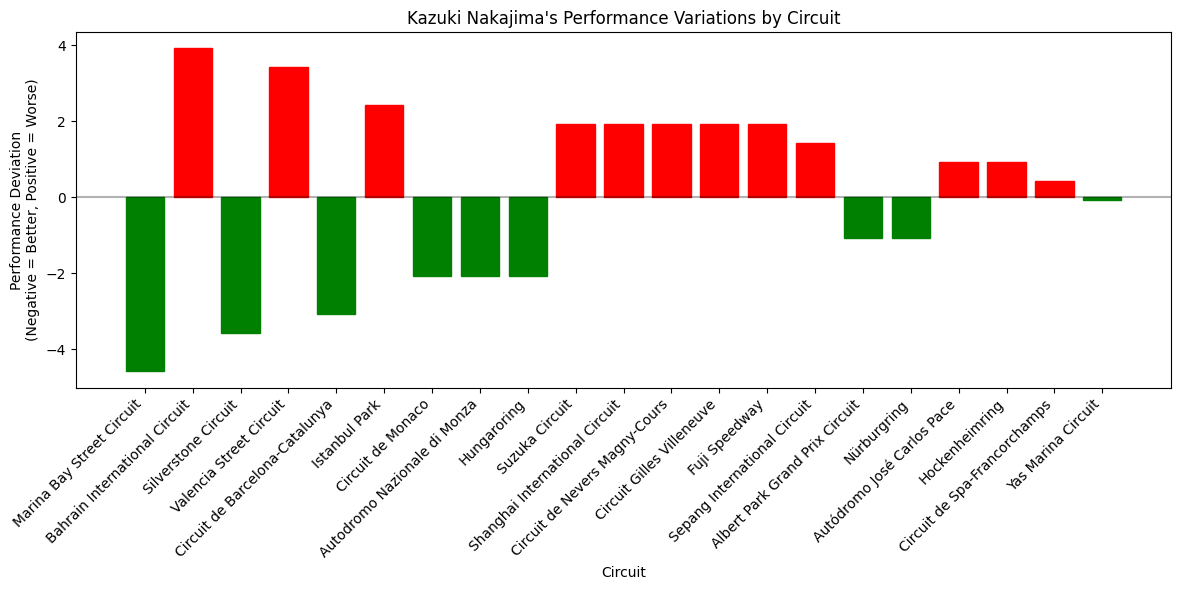

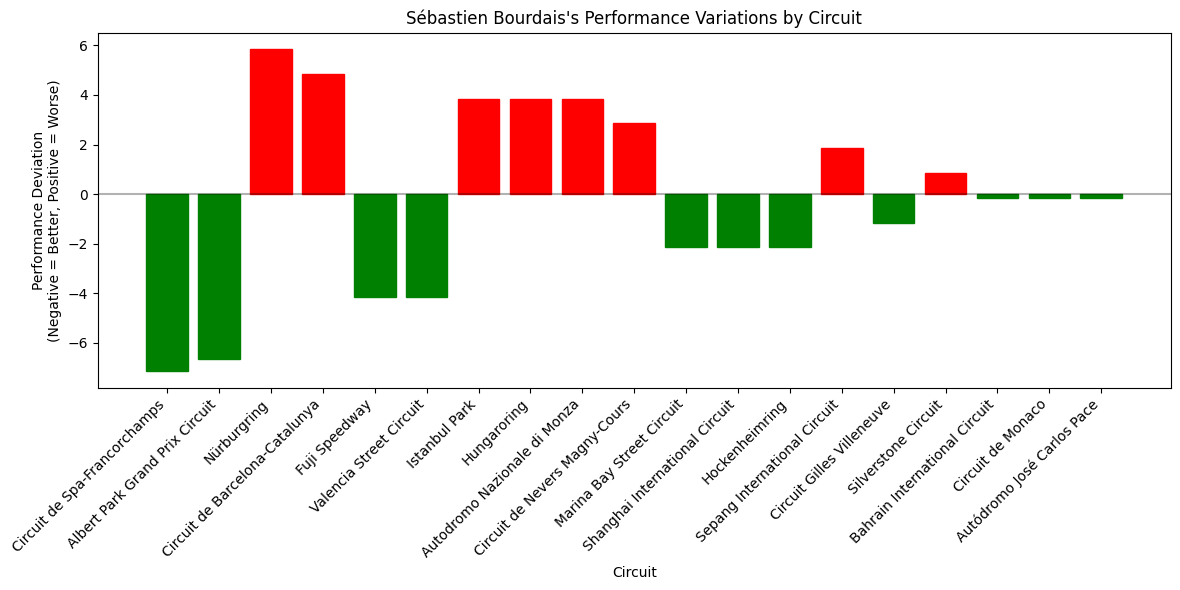

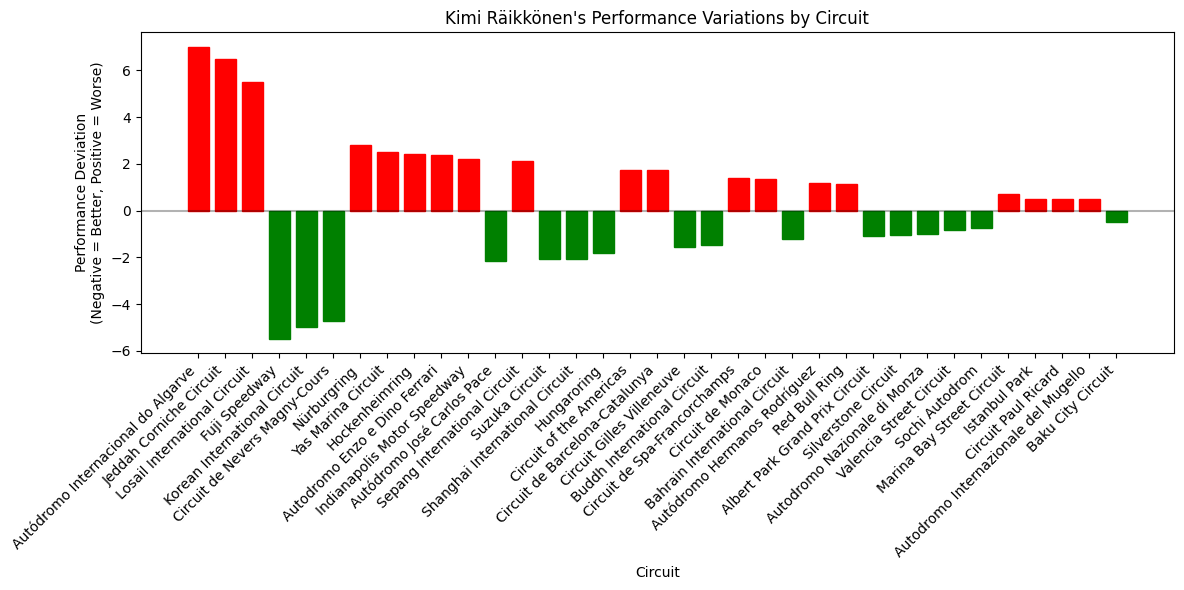

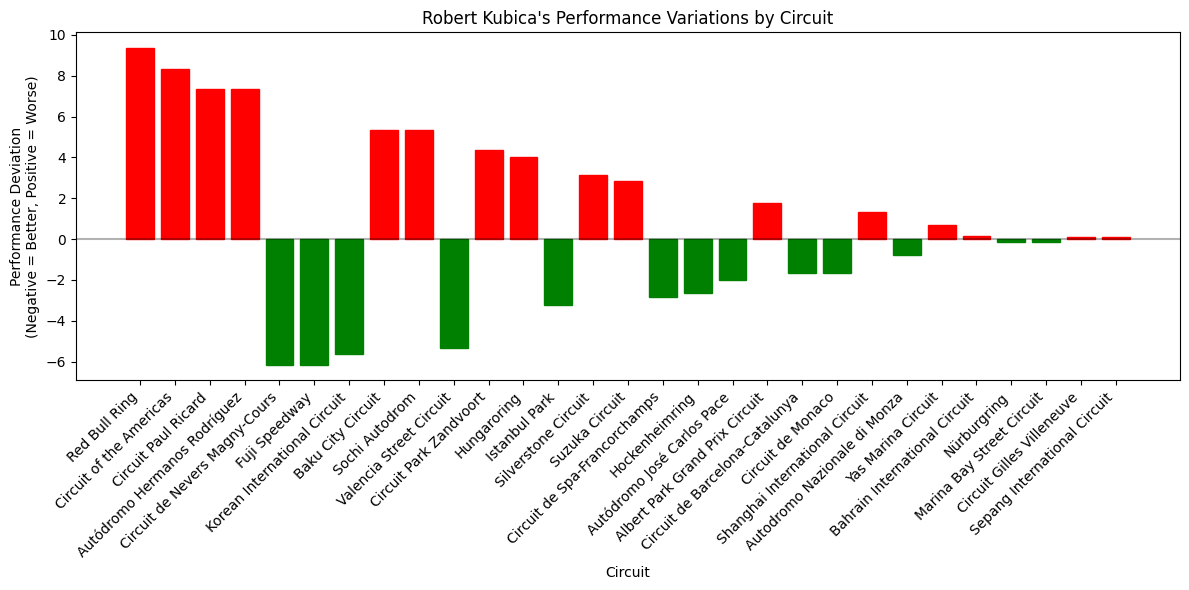

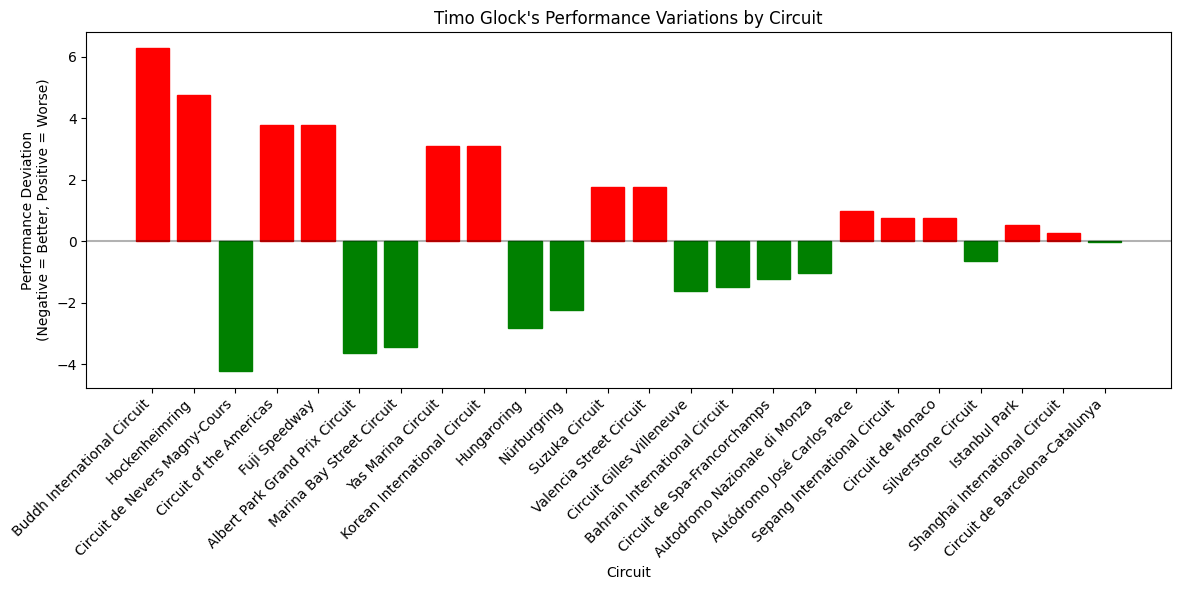

In [36]:
# Function to plot individual driver performance
def plot_driver_performance(driver_id, df_perf):
    driver_data = df_perf[df_perf['driverId'] == driver_id]
    driver_name = data[data['driverId'] == driver_id]['driverName'].iloc[0]
    driver_data = driver_data.sort_values(by='deviation', key=abs, ascending=False)
    plt.figure(figsize=(12, 6))
    bars = plt.bar(driver_data['circuitName'], driver_data['deviation'])
    
    # Color coding: red for positive deviations (worse performance), green for negative (better performance)
    for bar in bars:
        if bar.get_height() >= 0:
            bar.set_color('red')
        else:
            bar.set_color('green')
    
    plt.title(f"{driver_name}'s Performance Variations by Circuit")
    plt.xlabel('Circuit')
    plt.ylabel('Performance Deviation\n(Negative = Better, Positive = Worse)')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot for each qualified driver
for driver in qualified_drivers:
    plot_driver_performance(driver, driver_circuit_perf)


# Driver-Specific Track Performance Analysis

## Visualizations Used & Their Insights

### 1. Heatmap Analysis


 Key findings from heatmap visualization:
- Red cells indicate worse performance than driver's baseline
- Blue cells indicate better performance than baseline
- Intensity shows magnitude of deviation



**Inference:**
- Shows performance variations across all driver-circuit combinations
- Helps identify patterns of consistent performance or struggles
- Allows quick identification of tracks where multiple drivers excel or struggle

### 2. Radar Chart Analysis


 Radar chart interpretation:
- Distance from center indicates performance deviation
- Larger area = more variability across circuits
- Symmetrical shape = consistent performance



**Inference:**
- Shows individual driver's performance profile across all circuits
- Highlights strengths and weaknesses in a circular format
- Useful for identifying balanced vs specialized drivers

### 3. Bar Plot Analysis


Bar plot features:
- Green bars = Better than average performance
- Red bars = Worse than average performance
- Height = Magnitude of deviation



**Inference:**
- Clear visualization of each driver's best and worst circuits
- Easy to identify significant deviations from baseline
- Color coding provides immediate performance context

## Key Metrics Used

1. **Performance Deviation**


**deviation = circuit_avg_finish - overall_avg_finish**

- Negative values indicate better performance
- Positive values indicate worse performance

2. **Statistical Significance**
- Minimum race threshold (10 races) ensures reliable data
- Focus on top 10 drivers for meaningful analysis

